In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"numberggg","key":"ad0d797e12acd5d4413d11f1a62ac09c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d aneesh10/cricket-shot-dataset


Dataset URL: https://www.kaggle.com/datasets/aneesh10/cricket-shot-dataset
License(s): unknown
 98% 629M/645M [00:06<00:00, 153MB/s]
100% 645M/645M [00:06<00:00, 109MB/s]


In [ ]:
!unzip cricket-shot-dataset.zip -d ./cricket_shot_dataset


Archive:  cricket-shot-dataset.zip
  inflating: ./cricket_shot_dataset/data/drive/drives1.png  
  inflating: ./cricket_shot_dataset/data/drive/drives10.png  
  inflating: ./cricket_shot_dataset/data/drive/drives100.png  
  inflating: ./cricket_shot_dataset/data/drive/drives1000.png  
  inflating: ./cricket_shot_dataset/data/drive/drives1001.png  
  inflating: ./cricket_shot_dataset/data/drive/drives1002.jpeg  
  inflating: ./cricket_shot_dataset/data/drive/drives1003.png  
  inflating: ./cricket_shot_dataset/data/drive/drives1004.png  
  inflating: ./cricket_shot_dataset/data/drive/drives1005.png  
  inflating: ./cricket_shot_dataset/data/drive/drives1006.png  
  inflating: ./cricket_shot_dataset/data/drive/drives1007.png  
  inflating: ./cricket_shot_dataset/data/drive/drives1008.jpeg  
  inflating: ./cricket_shot_dataset/data/drive/drives1009.png  
  inflating: ./cricket_shot_dataset/data/drive/drives101.png  
  inflating: ./cricket_shot_dataset/data/drive/drives1010.png  
  inflatin

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Updated data_dir to point to the correct location
data_dir = './cricket_shot_dataset/data' # changed from /kaggle/input/cricket-shot-dataset/data to ./cricket_shot_dataset/data

image_paths = []
labels = []
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        if img_file.endswith(('.png', '.jpg', '.jpeg', '.webp')):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(class_to_idx[class_name])
train_paths,test_paths, train_labels, test_labels = train_test_split(image_paths,
                                                                     labels, test_size=0.2,
                                                                     stratify=labels,
                                                                     random_state=42)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [ ]:
train_dataset = CustomImageDataset(train_paths, train_labels, transform=transform)
test_dataset = CustomImageDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

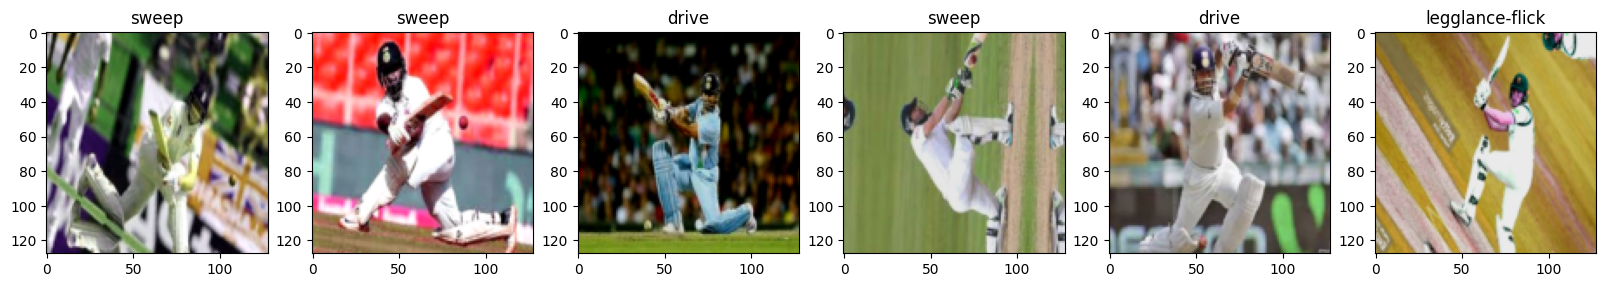

In [ ]:
def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        image, label = dataset[i]
        ax = axes[i]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(class_names[label])
    plt.show()

show_images(train_dataset)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.8073
Epoch 2, Loss: 0.3266
Epoch 3, Loss: 0.2702
Epoch 4, Loss: 0.1689
Epoch 5, Loss: 0.1086
Epoch 6, Loss: 0.0787
Epoch 7, Loss: 0.1055
Epoch 8, Loss: 0.0511
Epoch 9, Loss: 0.1928
Epoch 10, Loss: 0.0736
Epoch 11, Loss: 0.0457
Epoch 12, Loss: 0.1369
Epoch 13, Loss: 0.1041
Epoch 14, Loss: 0.1307
Epoch 15, Loss: 0.0946
Epoch 16, Loss: 0.0090
Epoch 17, Loss: 0.0514
Epoch 18, Loss: 0.1253
Epoch 19, Loss: 0.0557
Epoch 20, Loss: 0.0632


In [ ]:
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.95


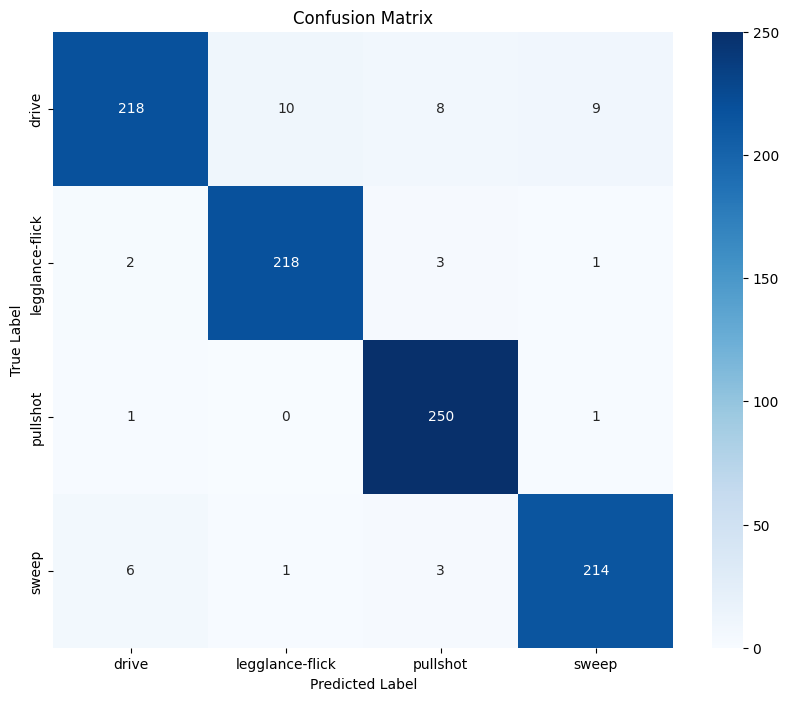

In [ ]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
cm = confusion_matrix(all_labels, all_preds)
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Define the confusion matrix from your image
conf_matrix = np.array([
    [218, 10, 8, 9],   # drive
    [2, 218, 3, 1],    # legglance-flick
    [1, 0, 250, 1],    # pullshot
    [6, 1, 3, 214]     # sweep
])

# Total number of samples (this should match for true and predicted labels)
true_labels = []
pred_labels = []

# Classes: 0 = drive, 1 = legglance-flick, 2 = pullshot, 3 = sweep
for true_class in range(4):
    for pred_class in range(4):
        count = conf_matrix[true_class, pred_class]
        true_labels.extend([true_class] * count)  # Add 'count' true labels for the true_class
        pred_labels.extend([pred_class] * count)  # Add 'count' predicted labels for the pred_class

# Convert to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Check if the lengths match
assert len(true_labels) == len(pred_labels), "The lengths of true and predicted labels should match."

# Calculate precision, recall, f1-score
precision = precision_score(true_labels, pred_labels, average=None)
recall = recall_score(true_labels, pred_labels, average=None)
f1 = f1_score(true_labels, pred_labels, average=None)

# Output precision, recall, and F1 score
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Classification report (includes precision, recall, F1, and support)
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=["drive", "legglance-flick", "pullshot", "sweep"]))


Precision: [0.96035242 0.95196507 0.9469697  0.95111111]
Recall: [0.88979592 0.97321429 0.99206349 0.95535714]
F1-Score: [0.92372881 0.96247241 0.96899225 0.9532294 ]

Classification Report:
                  precision    recall  f1-score   support

          drive       0.96      0.89      0.92       245
legglance-flick       0.95      0.97      0.96       224
       pullshot       0.95      0.99      0.97       252
          sweep       0.95      0.96      0.95       224

       accuracy                           0.95       945
      macro avg       0.95      0.95      0.95       945
   weighted avg       0.95      0.95      0.95       945



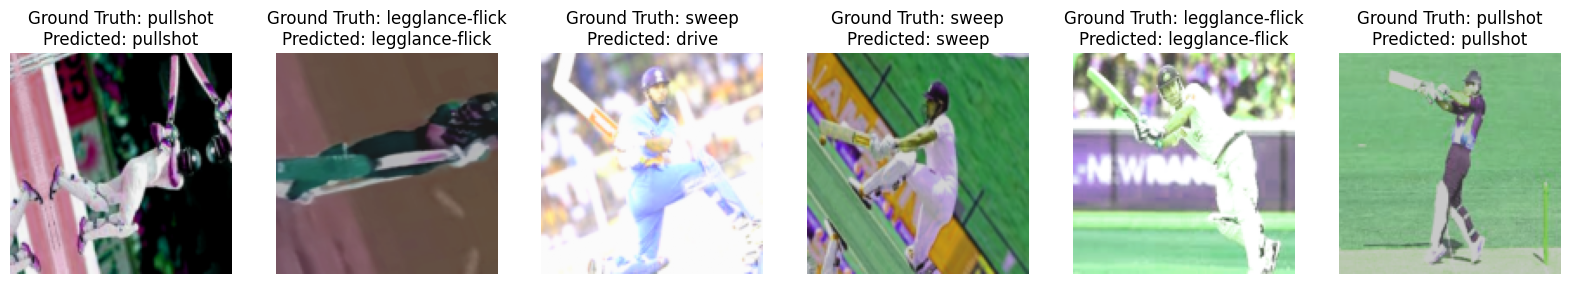

In [ ]:
def show_predictions(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        image, true_label = dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            _, pred_label = torch.max(output, 1)
        pred_label = pred_label.item()

        ax = axes[i]
        ax.imshow(image.squeeze().permute(1, 2, 0).cpu())
        ax.set_title(f"Ground Truth: {class_names[true_label]}\nPredicted: {class_names[pred_label]}")
        ax.axis('off')
    plt.show()

show_predictions(test_dataset)


In [ ]:
a

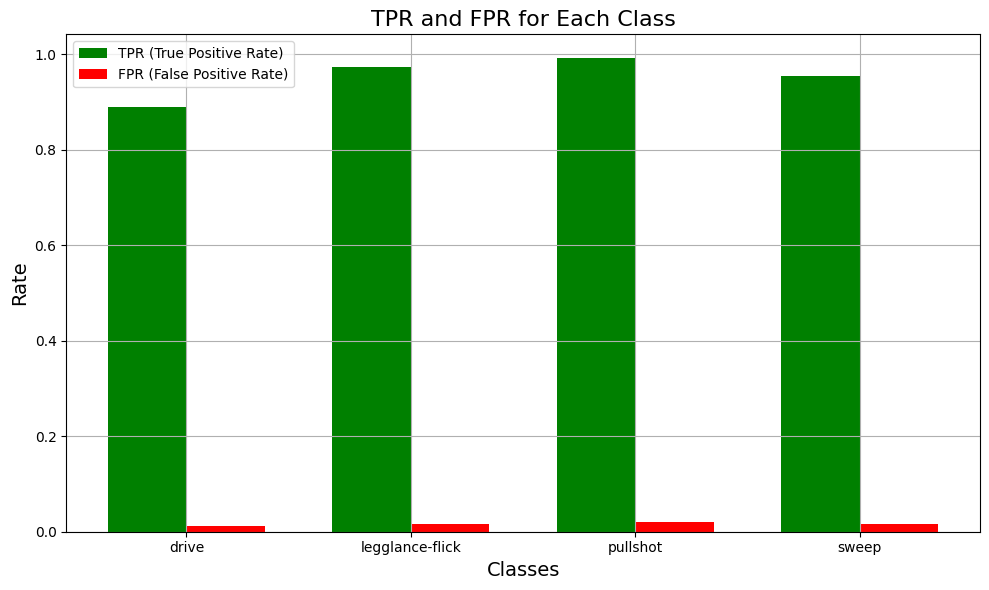

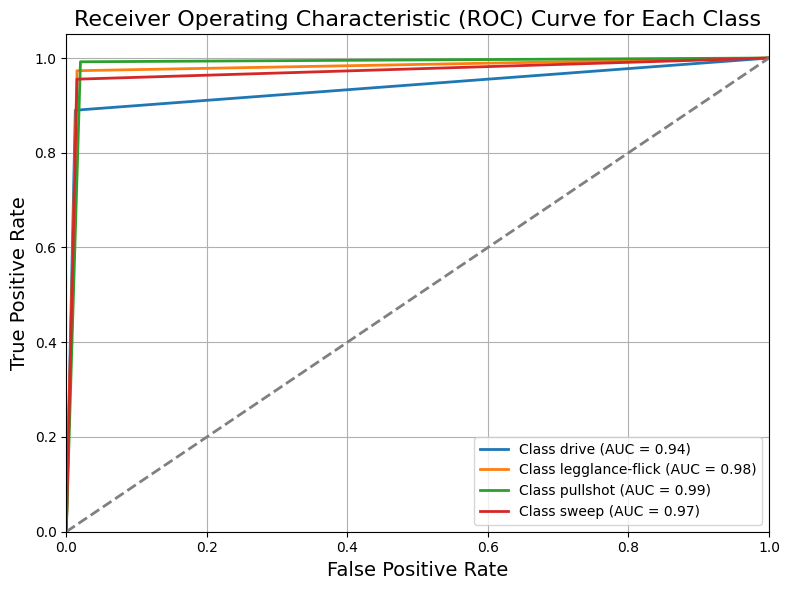

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Confusion matrix values (from the image provided)
confusion_matrix = np.array([
    [218, 10,  8,  9],  # drive
    [2, 218,  3,  1],   # legglance-flick
    [1,   0, 250, 1],   # pullshot
    [6,   1,   3, 214]  # sweep
])

# Number of classes
n_classes = confusion_matrix.shape[0]

# Class labels
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']

# Create true labels and predicted labels
true_labels = []
pred_labels = []

for i in range(n_classes):
    for j in range(n_classes):
        true_labels.extend([i] * confusion_matrix[i, j])  # Append true class labels
        pred_labels.extend([j] * confusion_matrix[i, j])  # Append predicted class labels

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Initialize arrays for TPR and FPR for each class
TPR = np.zeros(n_classes)
FPR = np.zeros(n_classes)

# Calculate TPR and FPR for each class
for i in range(n_classes):
    TP = confusion_matrix[i, i]  # True Positives
    FN = sum(confusion_matrix[i, :]) - TP  # False Negatives
    FP = sum(confusion_matrix[:, i]) - TP  # False Positives
    TN = sum(sum(confusion_matrix)) - (TP + FN + FP)  # True Negatives

    TPR[i] = TP / (TP + FN)  # True Positive Rate (Recall)
    FPR[i] = FP / (FP + TN)  # False Positive Rate

# Plotting the TPR/FPR bar plot
plt.figure(figsize=(10, 6))
x = np.arange(n_classes)
width = 0.35  # Bar width

# Bar chart for TPR
plt.bar(x - width/2, TPR, width, label='TPR (True Positive Rate)', color='green')

# Bar chart for FPR
plt.bar(x + width/2, FPR, width, label='FPR (False Positive Rate)', color='red')

# Add labels and title
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Rate', fontsize=14)
plt.title('TPR and FPR for Each Class', fontsize=16)

# Add x-ticks with class names
plt.xticks(x, class_names)

# Add a legend
plt.legend()

# Show grid
plt.grid(True)

# Show the bar plot
plt.tight_layout()
plt.show()

# Now, let's generate the ROC curve for each class
# Convert true labels to one-hot encoded format
y_test_bin = label_binarize(true_labels, classes=[0, 1, 2, 3])

# Create an empty plot for ROC curves
plt.figure(figsize=(8, 6))

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], label_binarize(pred_labels, classes=[0, 1, 2, 3])[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

# Plotting the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class', fontsize=16)

# Add a legend to identify each class
plt.legend(loc="lower right")

# Add grid to the plot
plt.grid(True)

# Show the ROC curve
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  # Import KMeans from sklearn.cluster
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']

# Assuming you have your training data in 'X_train'
# Replace 'X_train' with the actual name of your training data variable
X_train = np.random.rand(100, 2)  # Replace with your actual training data
train_features = X_train  # Assign your training features to 'train_features'

kmeans = KMeans(n_clusters=len(class_names), random_state=42)
kmeans.fit(train_features)

KMeans(n_clusters=4, random_state=42)

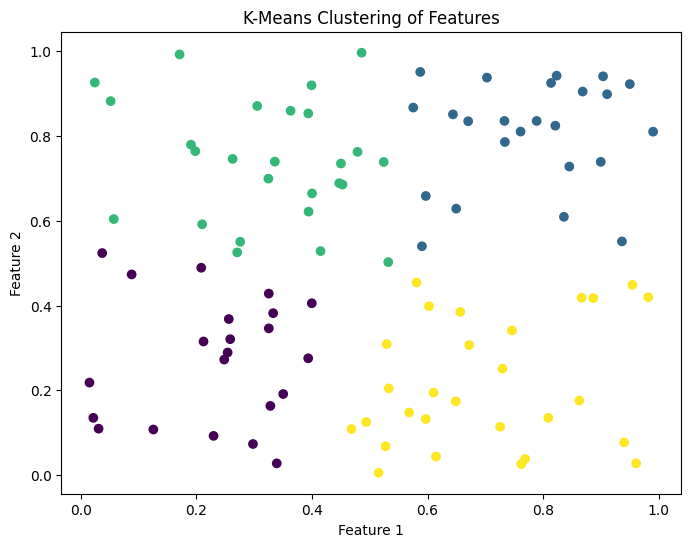

In [ ]:
kmeans = KMeans(n_clusters=len(class_names), random_state=42)
kmeans.fit(train_features)

# Visualize the clusters (optional)
plt.figure(figsize=(8, 6))
plt.scatter(train_features[:, 0], train_features[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('K-Means Clustering of Features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()